In [1]:
import pandas as pd
import numpy as np
import directories_to_use
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Load data rather than re-running data loading code
This only works if the code has been run at least once before.

In [2]:
X = np.load("X_phys.npy")
y = np.load("y_phys.npy")

## Put data into dataframes
We chose v1 of the 2015 dataset since it seems it is more representative of a normal operating condition in an ICS environment.

In [3]:
#Load the 2015 dataset
phys_dir = directories_to_use.getPhysicalDir()
df_attack = pd.read_excel(phys_dir + "SWaT_Dataset_Attack_v0.xlsx", header=1)
df_normal = pd.read_excel(phys_dir + "SWaT_Dataset_Normal_v1.xlsx", header=1)

E:\ProgramData\Anaconda2\envs\SWaT\lib\site-packages\openpyxl\worksheet\_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Put the 2017 dataset into dataframes

In [4]:
#Load the 2017 dataset
phys_dir_2 = directories_to_use.getPhysicalDir2017()
df_2017 = pd.read_excel(phys_dir_2 + "All.xlsx", header=1)
df_2017.columns = [d.strip() for d in df_2017.columns]

In [5]:
df_attack.columns = [d.strip() for d in df_attack.columns]
df_normal.columns = [d.strip() for d in df_normal.columns]


In [6]:
from datetime import datetime, timezone

def createTimestamp(datetime_string):
    if "." in datetime_string:
        row_date = datetime.strptime(datetime_string.strip(), "%d/%m/%Y %I:%M:%S.%f %p")
    else:
        row_date = datetime.strptime(datetime_string.strip(), "%d/%m/%Y %I:%M:%S %p")
    timestamp = row_date.replace(tzinfo=timezone.utc).timestamp()
    return timestamp

df_attack["Timestamp"] = df_attack["Timestamp"].apply(lambda x : createTimestamp(x))
df_normal["Timestamp"] = df_normal["Timestamp"].apply(lambda x : createTimestamp(x))
df_2017["Time"] = df_2017["Time"].apply(lambda x : createTimestamp(x))

In [7]:
def convertClassification(class_str):
    class_str = class_str.replace(" ", "")
    if class_str.strip() == "Normal":
        return 0
    elif class_str.strip() == "Attack":
        return 1
    else:
        return -1
    
df_attack["Normal/Attack"] = df_attack["Normal/Attack"].apply(lambda x : convertClassification(x))
df_normal["Normal/Attack"] = df_normal["Normal/Attack"].apply(lambda x : convertClassification(x))

In [21]:
df_attack.to_csv("PhysicalAttackDataframe.csv", index=False)
df_normal.to_csv("PhysicalNormalDataframe.csv", index=False)

In [20]:
df_2017["Normal/Attack"]  = np.zeros(df_2017.shape[0])
df_2017.to_csv("Physical2017Dataframe.csv", index=False)

In [22]:
data_attack = df_attack.to_numpy()
data_normal = df_normal.to_numpy()
data_2017 = df_2017.to_numpy()
np.save('physicalDataAttack.npy', data_attack)
np.save('physicalDataNormal.npy', data_normal)
np.save('physicalData2017.npy', data_2017)

In [24]:
data_full = np.concatenate((data_normal, data_attack, data_2017), axis=0)
data = data_full[:, 1:]
data.shape

(958580, 52)

In [31]:
X = data[: , :-1]
y = data[:, -1]
np.save("X_phys.npy",X)
np.save("y_phys.npy", y)
print(X.shape, y.shape)

(958580, 51) (958580,)


In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import matthews_corrcoef, make_scorer
h = .02  # step size in the mesh

names = [#"Nearest Neighbors", 
         #"Linear SVM", 
         #"RBF SVM", #"Gaussian Process",
         "Decision Tree", 
         "Random Forest", #"Neural Net", "AdaBoost",
         #"Naive Bayes", "QDA"
        ]

classifiers = [
    #KNeighborsClassifier(3),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    #MLPClassifier(alpha=1, max_iter=1000),
    #AdaBoostClassifier(),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis()
    ]


# iterate over classifiers
mcc = make_scorer(matthews_corrcoef)
scores = []
for name, clf in zip(names, classifiers):
    
    rcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2)
    scores.extend(cross_val_score(clf, X, y, cv=rcv, scoring="accuracy"))
    
    #clf.fit(X_data2019, y_data2019)
    #score = clf.score(X_data2017, y_data2017)
    
    print(name + ": " + str(np.mean(scores)) + " +- " + str(np.var(scores)))



Decision Tree: 0.9998163950843957 +- 1.2667655765640891e-09


## Simple visualisation of Physical data 
Just plots the register values (of all features against time <br>
This will only work with one dataset at a time - not both merged

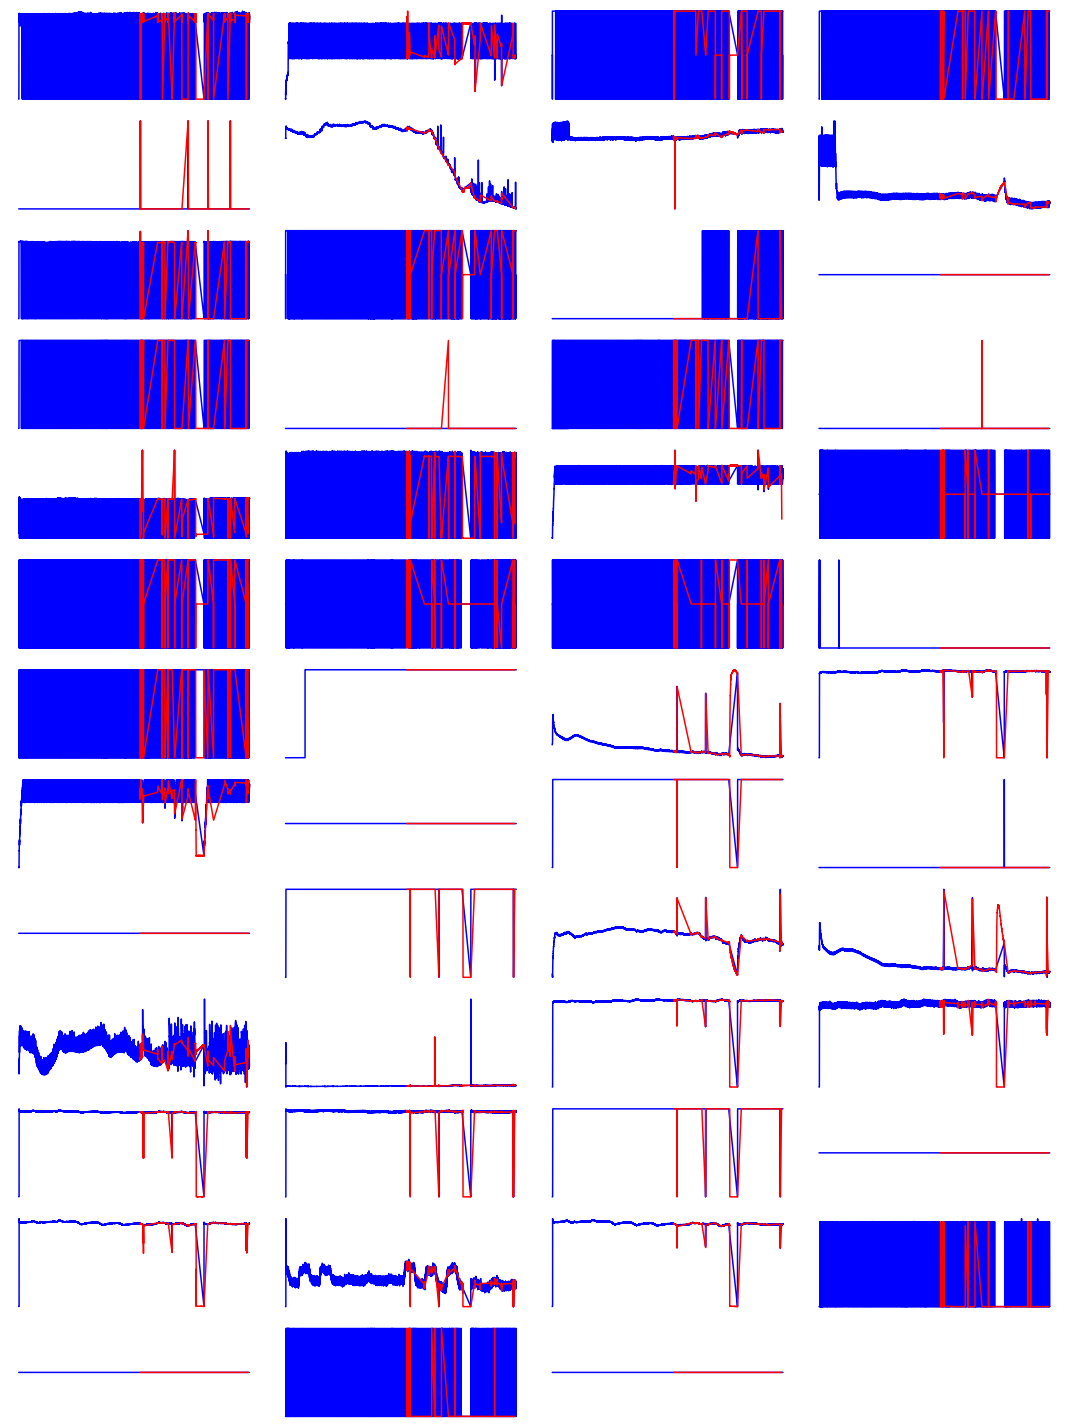

In [144]:
sns.set_theme()
no_of_columns = 4
no_of_rows = round(data_full.shape[1] / no_of_columns)
fig, axs = plt.subplots(no_of_rows, no_of_columns)
fig.set_size_inches(15, 20)
index = 1
for row_num in range(0, no_of_rows):
    for col_num in range(0, no_of_columns):
        if index <= X.shape[1]:
            axs[row_num][col_num].plot(data_full[data_full[:, -1] == 0][:, 0], data_full[data_full[:, -1] == 0][:, index], color="blue")
            axs[row_num][col_num].plot(data_full[data_full[:, -1] == 1][:, 0], data_full[data_full[:, -1] == 1][:, index], color="red")
            axs[row_num][col_num].axis('off')
            index+=1
        else:
            axs[row_num][col_num].axis('off')
plt.tight_layout()
plt.savefig('physical_registers.eps', format='eps', bbox_inches = 'tight',
    pad_inches = 0)